In [1]:
from main import MyPaddleOCR
import albumentations as A
import cv2
from matplotlib import pyplot as plt
import platform
import numpy as np
import pandas as pd
import os
from PIL import ImageFont, ImageDraw, Image
import IPython
from paddleocr import PaddleOCR, draw_ocr
from paddleocr.paddleocr import MODEL_URLS

In [2]:
ocr = PaddleOCR(lang="korean")

[2023/11/11 16:36:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\KNUVI/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\KNUVI/.paddleocr/whl\\rec\\korean\\korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_nu

In [3]:
def plt_imshow(title='image', img=None, figsize=(8, 5)):
    plt.figure(figsize=figsize)

    if type(img) is str:
        img = cv2.imread(img)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()


def put_text(image, text, x, y, color=(0, 255, 0), font_size=22):
    if type(image) == np.ndarray:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(color_coverted)

    # if platform.system() == 'Darwin':
    #     font = 'AppleGothic.ttf'
    # elif platform.system() == 'Windows':
    #     font = 'malgun.ttf'

    # image_font = ImageFont.truetype(font, font_size)
    # font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    # font=image_font
    draw.text((x, y), text, fill=color)

    numpy_image = np.array(image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    return opencv_image

In [5]:




def show_img(img_path):
    plt_imshow(img=img_path)
    
def run_ocr(img_path, debug):
    ocr_text = []
    print(1)
    result = ocr.ocr(img_path, cls=False)
    print(2)
    ocr_result = result[0]
    print(3)

    if ocr_result:
        for r in result[0]:
            ocr_text.append(r[1][0])
    else:
        ocr_text = "No text detected."

    if debug:
        show_img_with_ocr()

    return ocr_text

def show_img_with_ocr(img_path, ocr_result):
    img = cv2.imread(img_path)
    roi_img = img.copy()

    for text_result in ocr_result:
        text = text_result[1][0]
        tlX = int(text_result[0][0][0])
        tlY = int(text_result[0][0][1])
        trX = int(text_result[0][1][0])
        trY = int(text_result[0][1][1])
        brX = int(text_result[0][2][0])
        brY = int(text_result[0][2][1])
        blX = int(text_result[0][3][0])
        blY = int(text_result[0][3][1])

        pts = ((tlX, tlY), (trX, trY), (brX, brY), (blX, blY))

        topLeft = pts[0]
        topRight = pts[1]
        bottomRight = pts[2]
        bottomLeft = pts[3]

        cv2.line(roi_img, topLeft, topRight, (0, 255, 0), 2)
        cv2.line(roi_img, topRight, bottomRight, (0, 255, 0), 2)
        cv2.line(roi_img, bottomRight, bottomLeft, (0, 255, 0), 2)
        cv2.line(roi_img, bottomLeft, topLeft, (0, 255, 0), 2)
        #roi_img = put_text(roi_img, text, topLeft[0], topLeft[1] - 20, font_size=15)

        #print(text)

    plt_imshow(["Original", "ROI"], [img, roi_img], figsize=(16, 10))


In [6]:
# Declare an augmentation pipeline
transform = A.Compose([
    A.Resize(height = 812, width = 375),
    #A.RandomResizedCrop(p=1, height= 820 ,width= 820, scale=(0.65, 0.95),ratio=(0.90, 1.10)),
    A.RandomBrightnessContrast(always_apply=True, p=1.0, brightness_limit=(-0.4, 0.2), contrast_limit=(0.7, 0.9), brightness_by_max=False),
    #A.SafeRotate(always_apply=True, p=0.5, limit=(-10, 40), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
    #A.HorizontalFlip(always_apply=False, p=0.5),
    A.CenterCrop(always_apply=True, p=1, height=375, width=375)
    #    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0)
    #A.pytorch.transforms.ToTensorV2()
])
transform_o = A.Compose([
    A.Resize(height = 400, width = 256)
])

In [7]:
meds = ['zeromin', 'lepical', 'tylenol']
save_path = './Data/preprocessed_img_1/'
os.makedirs(save_path, exist_ok=True)

#0 resize h w center    bright      contrast
#1 812 375      375     -0.4 0.2    0.7 0.9

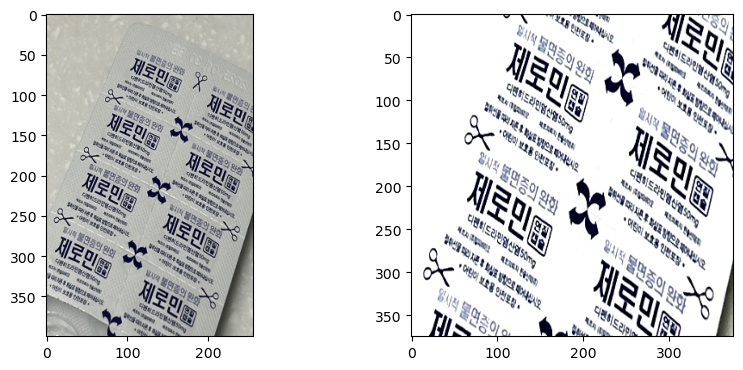

: 

In [8]:
for med in meds:
    img_path = './test_data/'+med+'.png'
    plt.figure(figsize=(10,200))
    im_bgr = cv2.imread(img_path)
    img = im_bgr[:, :, ::-1]
    transformed_img = transform(image=img)["image"]
    plt.subplot(40,2,1)
    plt.imshow(transform_o(image=img)['image'], cmap=plt.cm.binary)
    plt.grid(False)
    plt.subplot(40,2,2)
    plt.imshow(transformed_img, cmap=plt.cm.binary)
    plt.show()
    img_array = Image.fromarray(transformed_img.astype(np.uint8))
    file_name = f"{med}_preprocessed.jpg"
    img_array.save(os.path.join(save_path,file_name))
    img_path = os.path.join(save_path,file_name)
    result = ocr.ocr(img_path, cls=False)
    print(result)

In [ ]:
app = IPython.Application.instance()
app.kernel.do_shutdown(True)